# Restaurant Location

## Introduction

Santiago is the capital and largest city in Chile, with a population of over 6 million people and the most important city in terms of industry and finances, generating 45% of the country GDP, it attracts a lot of entrepeneurs to develop a new business here.

Santiago is divided in 35 Boroughs called *Comunas*, all connected through public transport. Each Comuna is different socially and economically, so it's important to make a difference between each of them.

In recent years the food scene has flourished in Santiago, with hundreds new restaurants showing a modern view of chilean cuisine as well as from international heritage.

### Business Project

Being such a large city with so much to offer, our main goal is to help future entrepeneurs looking to put a profitable restaurant, of any kind, in Santiago to choose the best location and improving the probability of success, we will take into consideration variables such as poverty index, population density and how well connected is through the city subway *Metro*

### Interests
Fellow entrepeneurs looking to develop a new business or expand an existing one, making decisions about location based in data, also this analysis can be aplicable to other kind of business such as pubs or clubs.

## Data acquisition

### Libraries needed

In [76]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library



print('Libraries imported.')


NotWritableError: The current user does not have write permissions to a required path.
  path: /home/lorena/.conda/pkgs/urls.txt
  uid: 1000
  gid: 1000

If you feel that permissions on this path are set incorrectly, you can manually
change them by executing

  $ sudo chown 1000:1000 /home/lorena/.conda/pkgs/urls.txt

In general, it's not advisable to use 'sudo conda'.



NotWritableError: The current user does not have write permissions to a required path.
  path: /home/lorena/.conda/pkgs/urls.txt
  uid: 1000
  gid: 1000

If you feel that permissions on this path are set incorrectly, you can manually
change them by executing

  $ sudo chown 1000:1000 /home/lorena/.conda/pkgs/urls.txt

In general, it's not advisable to use 'sudo conda'.


Libraries imported.


### List of  *Comunas* in Santiago, Chile

Import information of ***comunas*** in Santiago from Wikipedia

In [10]:
santiago_comunas = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile')[3]
print(santiago_comunas.shape)
santiago_comunas.head()

(36, 8)


,Comuna,Ubicación?,Población (2017)?,Viviendas (2002)?,Densidad poblacional (2002) ?,Crecimiento demográfico (2002-2017)?,ICVU (2019)?,Pobreza (2015)?
0,Cerrillos,surponiente,80832,19811.0,4329.08,12.9%,47.82 (74),19.7
1,Cerro Navia,norponiente,132622,35277.0,13482.91,-10.7%,42.42 (92),35.6
2,Conchalí,norte,126955,32609.0,12070.29,-4.4%,46.52 (84),21.6
3,El Bosque,sur,162505,42808.0,12270.72,-7.3%,48.54 (70),27.0
4,Estación Central,surponiente,147041,32357.0,9036.31,16.6%,49.96 (64),14.5


Importing the postcode of every *comuna* in Chile from Wikipedia

In [11]:
post_chile = pd.read_html('https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_postales_de_Chile')[0]
post_chile.rename(columns={'Comuna/localidad':'Comuna','Código':'Codigo'},inplace=True)
 
print(post_chile.shape)
post_chile.head()

(344, 2)


,Comuna,Codigo
0,Algarrobo,2710000
1,Alhué,9650000
2,Alto Biobío,4590000
3,Alto del Carmen,1650000
4,Alto Hospicio,1130000


Cleaning the dataframe to leave only the information needed

In [12]:
santiago_comunas.drop([santiago_comunas.columns[1],santiago_comunas.columns[2],santiago_comunas.columns[3],santiago_comunas.columns[5],santiago_comunas.columns[6]], axis=1, inplace=True)
santiago_comunas.rename(columns={'Pobreza (2015)?':'Poverty index'},inplace = True)
santiago_comunas.rename(columns={'Densidad poblacional (2002) ?':'Population Density'},inplace = True)
santiago_comunas.dropna(axis=0,inplace=True)
santiago_comunas.head()

,Comuna,Population Density,Poverty index
0,Cerrillos,4329.08,19.7
1,Cerro Navia,13482.91,35.6
2,Conchalí,12070.29,21.6
3,El Bosque,12270.72,27.0
4,Estación Central,9036.31,14.5


Merging both dataframe to leave the name of the column with its postcode

In [13]:
Santiago = pd.merge(post_chile , santiago_comunas, on='Comuna', how='inner')
Santiago.reset_index()
print(Santiago.shape)
Santiago.head()

(35, 4)


,Comuna,Codigo,Population Density,Poverty index
0,Cerrillos,9200000,4329.08,19.7
1,Cerro Navia,9080000,13482.91,35.6
2,Conchalí,8540000,12070.29,21.6
3,El Bosque,8010000,12270.72,27.0
4,Estación Central,9160000,9036.31,14.5


### Importing geolocation information of every borough in Chile

In [14]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
from urllib.request import urlopen
# or: requests.get(url).content

resp = urlopen('http://download.geonames.org/export/zip/CL.zip')
zipfile = ZipFile(BytesIO(resp.read()))

#txt_chile = zipfile.read('CL.txt')

columns_geodata =['Country code','Postal code','Place name','Admin name1','Admin code1','Admin name2','Admin code2','Admin name3','Admin code3','lat','lng','accuracy']
geodata_chile = pd.read_csv(zipfile.open('CL.txt'),names = ['Name'])
geodata_chile.head()


,Name
0,CL\t2340000\tValparaíso\tRegión de Valparaíso\...
1,CL\t2480000\tCasablanca\tRegión de Valparaíso\...
2,CL\t2490000\tQuintero\tRegión de Valparaíso\t0...
3,CL\t2500000\tPuchuncaví\tRegión de Valparaíso\...
4,CL\t2510000\tConcón\tRegión de Valparaíso\t01\...


In [15]:
# Cleaning the dataframe

geodata_chile[columns_geodata] = geodata_chile.Name.str.split("\t",expand=True) 
geodata_chile.drop(['Name'],axis=1,inplace=True)
geodata_chile.head()

,Country code,Postal code,Place name,Admin name1,Admin code1,Admin name2,Admin code2,Admin name3,Admin code3,lat,lng,accuracy
0,CL,2340000,Valparaíso,Región de Valparaíso,01,Provincia de Valparaíso,51,Valparaíso,05101,-33.1298,-71.5735,4
1,CL,2480000,Casablanca,Región de Valparaíso,01,Provincia de Valparaíso,51,Casablanca,05102,-33.3158,-71.4353,4
2,CL,2490000,Quintero,Región de Valparaíso,01,Provincia de Valparaíso,51,Quintero,05107,-32.843,-71.4738,4
3,CL,2500000,Puchuncaví,Región de Valparaíso,01,Provincia de Valparaíso,51,Puchuncaví,05105,-32.7176,-71.4111,4
4,CL,2510000,Concón,Región de Valparaíso,01,Provincia de Valparaíso,51,Concón,05103,-32.9534,-71.4678,4


In [18]:
# Dropping innecessary information

new_geo_df = geodata_chile[['Postal code','lat','lng']]
new_geo_df.rename(columns={'Postal code':'Codigo'},inplace = True)


new_geo_df = new_geo_df.astype({'Codigo':'int64'})
print(new_geo_df.dtypes)


new_geo_df.head()

Codigo     int64
lat       object
lng       object
dtype: object


,Codigo,lat,lng
0,2340000,-33.1298,-71.5735
1,2480000,-33.3158,-71.4353
2,2490000,-32.843,-71.4738
3,2500000,-32.7176,-71.4111
4,2510000,-32.9534,-71.4678


In [19]:
import unicodedata


santiago_geolocation = pd.merge(Santiago , new_geo_df, on='Codigo', how='inner')
print(santiago_geolocation.shape)
print(santiago_geolocation.dtypes)

# Remove accents
import unidecode
santiago_geolocation['Comuna'] = santiago_geolocation['Comuna'].apply(unidecode.unidecode)


santiago_geolocation.head()


(35, 6)
Comuna                 object
Codigo                  int64
Population Density    float64
Poverty index         float64
lat                    object
lng                    object
dtype: object


,Comuna,Codigo,Population Density,Poverty index,lat,lng
0,Cerrillos,9200000,4329.08,19.7,-33.5003,-70.7174
1,Cerro Navia,9080000,13482.91,35.6,-33.4228,-70.745
2,Conchali,8540000,12070.29,21.6,-33.3837,-70.6774
3,El Bosque,8010000,12270.72,27.0,-33.5629,-70.6764
4,Estacion Central,9160000,9036.31,14.5,-33.4645,-70.6986


# Map of Santiago

In [38]:
from matplotlib import pyplot as plt

#Santiago Latitude and Longitude
latitude =-33.416889
longitude= -70.606705

# create map of Santiago using latitude and longitude values
map_santiago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(santiago_geolocation['lat'], santiago_geolocation['lng'], santiago_geolocation['Comuna']):
    label = '{}'.format(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago)  
    
plt.savefig('santiago_comunas.pdf')

map_santiago




<Figure size 432x288 with 0 Axes>

## Looking for existing venues in Santiago

### Foursquare Credential and Version

In [50]:
CLIENT_ID = -------------------------------------------------- # your Foursquare ID
CLIENT_SECRET = ---------------------------------------------- # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 32TMXOPLKYMNKCHQB5FX0UWRG2TAVTPM13K0GLVZYLJZBEUG
CLIENT_SECRET:P5IYLFARAC1JI0DZNUWNZJ2R3MA0CR0CPK5PR0HMTHI0PL1T


In [51]:
pizza_category = '4bf58dd8d48988d1ca941735' #Category ID for pizza place
metro_category = '4bf58dd8d48988d1fd931735'

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Comuna', 
                  'Comuna Latitude', 
                  'Comuna Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Running the code for each Borough

In [53]:
# type your answer here

santiago_venues = getNearbyVenues(names=santiago_geolocation['Comuna'],
                                   latitudes=santiago_geolocation['lat'],
                                   longitudes=santiago_geolocation['lng']
                                  )

Cerrillos
Cerro Navia
Conchali
El Bosque
Estacion Central
Huechuraba
Independencia
La Cisterna
La Florida
La Granja
La Pintana
La Reina
Las Condes
Lo Barnechea
Lo Espejo
Lo Prado
Macul
Maipu
Nunoa
Padre Hurtado
Pedro Aguirre Cerda
Penalolen
Providencia
Pudahuel
Puente Alto
Quilicura
Quinta Normal
Recoleta
Renca
San Bernardo
San Joaquin
San Miguel
San Ramon
Santiago
Vitacura


In [54]:
print(santiago_venues.shape)
santiago_venues.head()

(268, 7)


,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,-33.5003,-70.7174,ShopDog Plaza Oeste,-33.501138,-70.717802,Fast Food Restaurant
1,Cerrillos,-33.5003,-70.7174,Villa El Sendero,-33.499269,-70.715839,Plaza
2,Cerrillos,-33.5003,-70.7174,El Cometa,-33.498666,-70.716588,Restaurant
3,Cerrillos,-33.5003,-70.7174,Supermercados Erbi,-33.500143,-70.718540,Grocery Store
4,Cerro Navia,-33.4228,-70.745,Farmacias Cruz Verde,-33.426531,-70.742985,Pharmacy


In [28]:
df_com = santiago_venues.groupby('Comuna').count()
df_com = df_com.sort_values('Venue',ascending=False).reset_index()
df_com.head()

,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Providencia,29,29,29,29,29,29
1,Vitacura,25,25,25,25,25,25
2,San Miguel,24,24,24,24,24,24
3,Santiago,23,23,23,23,23,23
4,Nunoa,22,22,22,22,22,22


In [29]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print(df_com.shape)


Matplotlib version:  3.1.1
(31, 7)


## Plot to look for more *commercial* Comunas in Santiago

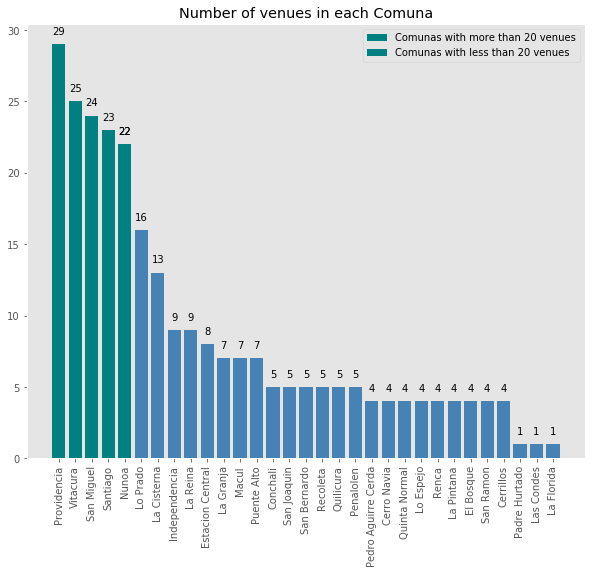

In [31]:
#Plot of number of venues in each comuna

fig,ax= plt.subplots(figsize=(10,8))

labels = ['Comunas with more than 20 venues', 'Comunas with less than 20 venues']

colors = {'Comunas with more than 20 venues':'teal',
          'Comunas with less than 20 venues': 'steelblue'}



df_com['colors'] = 'steelblue'
df_com.loc[df_com['Venue']>=20,'colors'] = 'teal'

df_com1 = df_com.head(5)
df_com2 = df_com.tail(27)
plt.bar(df_com1['Comuna'],df_com1['Venue'], color=df_com1.colors, label='Comunas with more than 20 venues')
plt.bar(df_com2['Comuna'],df_com2['Venue'], color=df_com2.colors, label='Comunas with less than 20 venues')
plt.title('Number of venues in each Comuna') # add title to the plot

# Create legend
plt.legend()

plt.xticks(rotation=90, ha='center')


# zip joins x and y coordinates in pairs
for x,y in zip(df_com1['Comuna'],df_com1['Venue']):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# zip joins x and y coordinates in pairs
for x,y in zip(df_com2['Comuna'],df_com2['Venue']):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.grid(b=None)

plt.savefig('Venues_comuna.pdf', bbox_inches = "tight")


plt.show()




We can make a comparison with the wealth of each ***Comuna*** by accounting the poverty index



In [32]:
comuna_venues=df_com[['Comuna','Venue']]
Santiago_pov = santiago_geolocation[['Comuna', 'Poverty index']]

Santiago_2 = pd.merge(comuna_venues , Santiago_pov , on='Comuna', how='inner')
Santiago_2.head()

,Comuna,Venue,Poverty index
0,Providencia,29,4.6
1,Vitacura,25,2.8
2,San Miguel,24,11.6
3,Santiago,23,11.6
4,Nunoa,22,10.7


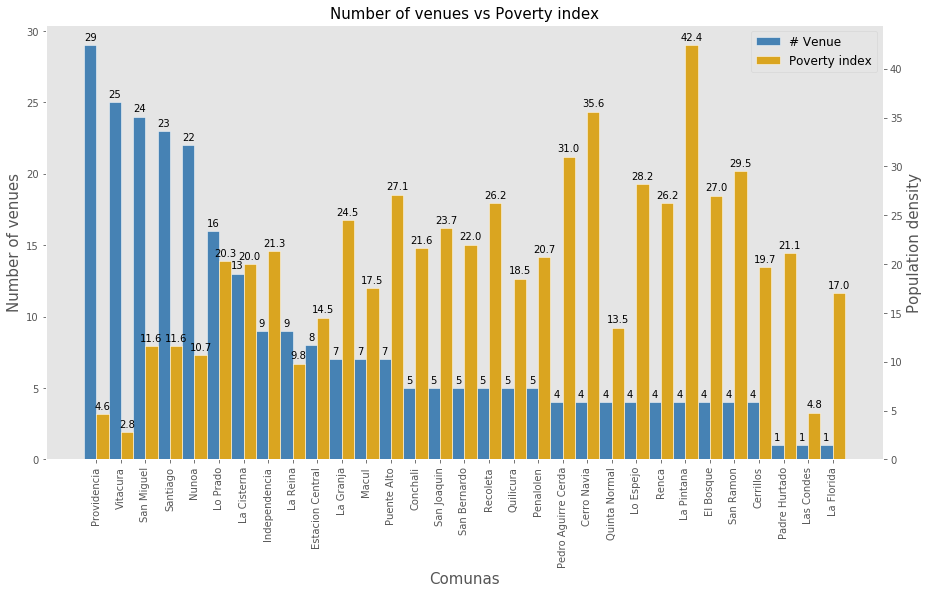

In [33]:
fig,ax = plt.subplots(figsize=(15,8))

# set width of bar
barWidth = 0.5
 
# set height of bar
bars1 = Santiago_2['Venue']
bars2 = Santiago_2['Poverty index']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.title('Number of venues vs Poverty index', fontsize=15)
ax.set_ylabel('Number of venues', fontsize=15)
ax.set_xlabel('Comunas', fontsize=15) 
plt.xticks([r + barWidth/2 for r in range(len(bars1))], Santiago_2['Comuna'],rotation=90)

S3=ax.bar(r1, bars1, color='steelblue', width=barWidth, edgecolor='white', label='# Venue')

ax.tick_params(axis='y')


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.bar(r2, bars2, color='goldenrod', width=barWidth, edgecolor='white', label='Poverty index')

ax2.set_ylabel('Population density', fontsize=15)
F3 = ax2.bar(r2, bars2, color='goldenrod', width=barWidth, edgecolor='white', label='Poverty index')

ax2.tick_params(axis='y')

plt.grid(b=None)
ax.grid(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def autolabel1(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax2.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(S3)
autolabel1(F3)

ax.legend( [S3,F3], ['# Venue','Poverty index'], loc="upper right",fontsize = 12, frameon=True)

plt.savefig('Venues_poverty.pdf', bbox_inches = "tight")

We will choose the first 5 ***comunas*** with the most venues i.e. the most commercial boroughs as shown in the first graph

In [34]:
df_com = df_com.head(5)
df_com

,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,colors
0,Providencia,29,29,29,29,29,29,teal
1,Vitacura,25,25,25,25,25,25,teal
2,San Miguel,24,24,24,24,24,24,teal
3,Santiago,23,23,23,23,23,23,teal
4,Nunoa,22,22,22,22,22,22,teal


In [35]:
san_venues = santiago_venues.loc[santiago_venues['Comuna'].isin(['Providencia','Nunoa','San Miguel','Vitacura','Santiago'])]
#san_venues.drop('index', axis=1, inplace=True)
#san_venues.drop([san_venues.columns[0]], axis=1, inplace=True)
san_venues.reset_index(inplace=True)

print(san_venues.shape)
san_venues.head()

(123, 8)


,index,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,96,Nunoa,-33.4593,-70.6003,Piscina Olimpica Estadio Nacional,-33.459902,-70.598820,Gym Pool
1,97,Nunoa,-33.4593,-70.6003,Plaza Ñuñoa,-33.459914,-70.598809,Plaza
2,98,Nunoa,-33.4593,-70.6003,La Postrería,-33.459090,-70.596111,Dessert Shop
3,99,Nunoa,-33.4593,-70.6003,Centro Zen,-33.457752,-70.602795,Yoga Studio
4,100,Nunoa,-33.4593,-70.6003,Minimarket El Vecino,-33.457806,-70.599864,Grocery Store


Analizing each ***comuna*** to see how many venues of each type have


In [36]:
santiago_sum = pd.get_dummies(san_venues, columns=['Venue Category'], prefix="", prefix_sep="").groupby(['Comuna'], as_index=False).sum()
santiago_sum.drop([santiago_sum.columns[1],santiago_sum.columns[2],santiago_sum.columns[3]], axis=1, inplace=True)
santiago_sum

,Comuna,Auto Workshop,BBQ Joint,Bakery,Bar,Breakfast Spot,Building,Bus Station,Café,Candy Store,Cheese Shop,Chinese Restaurant,Coffee Shop,College Rec Center,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,History Museum,Hot Dog Joint,Hotel,Ice Cream Shop,Latin American Restaurant,Liquor Store,Metro Station,Miscellaneous Shop,Mountain,Moving Target,Office,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Temple,Tennis Court,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Watch Shop,Yoga Studio
0,Nunoa,1,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,2,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,1
1,Providencia,0,1,0,1,2,0,0,2,0,0,1,0,0,1,0,0,0,1,0,0,0,1,2,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,2,0,0,3,0,2,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,San Miguel,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,1,2,0,0,2,0,0,0,0,0,5,0,0,0,0,0,0,0
3,Santiago,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,1,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0
4,Vitacura,0,0,1,0,0,0,0,2,1,0,0,3,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2,0,2,1,1,0,0,1,0,1,0,1,1


## Map showing existing venues in the chosen Comunas


In [57]:
from folium import plugins

#Santiago Latitude and Longitude
latitude =-33.416889
longitude= -70.606705

# let's start again with a clean copy of the map of San Francisco
comunas_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster().add_to(comunas_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(san_venues['Venue Latitude'], san_venues['Venue Longitude'], san_venues['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
        parse_html=False).add_to(venues)
    
    

# display map
comunas_map 

### Google maps API credentials to get the number and geolocation of subway stations

In [58]:
import googlemaps
from googleplaces import GooglePlaces, types, lang
import pprint
import time
#from GoogleMapsAPIKey import get_my_key

YOUR_API_KEY = ------------------------------

#Set Google Maps API key

google_places = GooglePlaces(YOUR_API_KEY)

#geolocation of chosen comunes
sant_df = santiago_geolocation.loc[santiago_geolocation['Comuna'].isin(['Providencia','Nunoa','San Miguel','Vitacura','Santiago'])]
sant_df.reset_index 

# creating a list of dataframe columns 
lat_list = list(sant_df['lat']) 
lng_list = list(sant_df['lng']) 

#empty list to create a dataframe
metro_names = []
metro_lats = []
metro_lng = []
metro_com = []
for i in range(0,len(lat_list)): 

    santiago_metro = google_places.nearby_search(lat_lng={'lat' : lat_list[i], 'lng' : lng_list[i]}, radius=5000,types=[types.TYPE_SUBWAY_STATION])    
        
    #search for subways stations in Santiago
   
    
    for place in santiago_metro.places:
        place.get_details()
        #pprint.pprint(place.details)
        #print(place.details['address_components'][1]['long_name'])
        metro_names.append(place.name)
        metro_lats.append(place.details['geometry']['location']['lat'])
        metro_lng.append(place.details['geometry']['location']['lng'])
        metro_com.append(place.details['address_components'][2]['long_name'])
        
print('-----------------------------------------')
print('Metro details finished!')
print('-----------------------------------------')


-----------------------------------------
Metro details finished!
-----------------------------------------


In [59]:
#Creating a dataframe with the information fetched with GoogleMaps API

metro_df = pd.DataFrame([metro_names, metro_com, metro_lats, metro_lng])

metro_df= np.transpose(metro_df)
metro_df.columns=['Name','Comuna','lat','lng']
print(metro_df.shape)
metro_df

(86, 4)


,Name,Comuna,lat,lng
0,Irarrázaval (L5-L3),Ñuñoa,-33.453135,-70.62892939999999
1,Chile-España,Ñuñoa,-33.45513620000001,-70.5974677
2,Estadio Nacional,Ñuñoa,-33.462282,-70.60611299999999
3,Ñuñoa,Ñuñoa,-33.4546207,-70.60460189999999
4,Mons. Eyzaguirre,Ñuñoa,-33.453164,-70.61383499999999
5,Villa Frei,Ñuñoa,-33.45461799999999,-70.58098699999999
6,Ines de Suárez,Providencia,-33.438878,-70.60720100000002
7,Ñuble,Ñuñoa,-33.4674903,-70.6247183
8,Los Orientales,Ñuñoa,-33.4624399,-70.5739257
9,Grecia,Peñalolén,-33.468819,-70.57620199999999


In [60]:
#Dropping duplicate rows

metro_df.drop_duplicates(subset ="Name", 
                     keep = 'first', inplace = True) 
metro_df.reset_index(drop=True, inplace=True)
metro_df = metro_df.astype({'lat': 'float64'})
metro_df =metro_df.astype({'lng': 'float64'})


#remove accents
metro_df['Name'] = metro_df['Name'].apply(unidecode.unidecode)
metro_df['Comuna'] = metro_df['Comuna'].apply(unidecode.unidecode)

metroindex = metro_df[(metro_df['Comuna'] != 'Nunoa') & (metro_df['Comuna'] != 'Providencia') & (metro_df['Comuna'] != 'Santiago')& (metro_df['Comuna'] != 'San Miguel')  & (metro_df['Comuna'] != 'Vitacura')].index
metro_df.drop(metroindex , inplace=True)

print(metro_df.shape)
print(metro_df.dtypes)
metro_df.head()

(48, 4)
Name       object
Comuna     object
lat       float64
lng       float64
dtype: object


,Name,Comuna,lat,lng
0,Irarrazaval (L5-L3),Nunoa,-33.453135,-70.628929
1,Chile-Espana,Nunoa,-33.455136,-70.597468
2,Estadio Nacional,Nunoa,-33.462282,-70.606113
3,Nunoa,Nunoa,-33.454621,-70.604602
4,Mons. Eyzaguirre,Nunoa,-33.453164,-70.613835


In [46]:
metro_gb =metro_df.groupby('Comuna').count()

metro_gb.drop([metro_gb.columns[1],metro_gb.columns[2]], axis=1, inplace=True)
metro_gb.rename(columns={'Name':'Metro count'},inplace = True)



df2 = pd.DataFrame({'Comuna':['Vitacura'],'Metro count':[0]})

#metro_gb= metro_gb.append(df2)

metro_gb.reset_index(inplace = True)
metro_gb = metro_gb.append(df2)
metro_gb.reset_index(inplace=True)
metro_gb.drop([metro_gb.columns[0]], axis=1, inplace=True)
metro_gb

,Comuna,Metro count
0,Nunoa,11
1,Providencia,11
2,San Miguel,5
3,Santiago,21
4,Vitacura,0


# Map Showing existing subways and venues in Santiago

In [64]:
#Santiago Latitude and Longitude
latitude =-33.416889
longitude= -70.606705

# let's start again with a clean copy of the map of Santiago
comunas_map1 = folium.Map(location = [latitude, longitude], zoom_start = 11)

# instantiate a mark cluster object for the incidents in the dataframe
venues1 = plugins.MarkerCluster().add_to(comunas_map1)

# instantiate a mark cluster object for the incidents in the dataframe
venues2 = plugins.MarkerCluster().add_to(comunas_map1)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(san_venues['Venue Latitude'], san_venues['Venue Longitude'], san_venues['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
        parse_html=False).add_to(venues1)
 

    

# add markers to map
for lat, lng in zip(metro_df['lat'], metro_df['lng']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(venues1)  
    


    

# display map
comunas_map1 

# Create dataframe to make a predictive model

In [65]:
K_santiago_df = pd.merge(santiago_geolocation , df_com[['Comuna','Venue']] , on='Comuna', how='inner')
K_santiago_df = pd.merge(K_santiago_df , metro_gb , on='Comuna', how='inner')

#Dropping unnecesary information and categorical variables
K_santiago_df.drop([K_santiago_df.columns[0],K_santiago_df.columns[1],K_santiago_df.columns[4],K_santiago_df.columns[5]], axis=1, inplace=True)

K_santiago_df

,Population Density,Poverty index,Venue,Metro count
0,9698.16,10.7,22,11
1,8429.15,4.6,29,11
2,8122.76,11.6,24,5
3,8654.83,11.6,23,21
4,2846.63,2.8,25,0


### Normalize Data

In [66]:
from sklearn import preprocessing

X = K_santiago_df

X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.89095903,  0.64536716, -1.07588766,  0.19910804],
       [ 0.36455644, -0.96805074,  1.82073295,  0.19910804],
       [ 0.2374617 ,  0.88341242, -0.24828177, -0.65421214],
       [ 0.45817157,  0.88341242, -0.66208471,  1.62130835],
       [-1.95114873, -1.44414126,  0.16552118, -1.3653123 ]])

### Cluster the information

In [67]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 1, 1, 0], dtype=int32)

### Creating a new Dataframe that has the information of clusters

In [68]:
# add clustering labels
#K_santiago_df.insert(0, 'Cluster Labels', kmeans.labels_)

K_santiago_df1  = pd.merge(santiago_geolocation , df_com[['Comuna','Venue']] , on='Comuna', how='inner')
K_santiago_df1 = pd.merge(K_santiago_df1 , metro_gb , on='Comuna', how='inner')
K_santiago_df1.insert(0, 'Cluster Labels', kmeans.labels_)

K_santiago_df1 = K_santiago_df1[['Comuna', 'Population Density', 'Poverty index','lat','lng','Venue','Metro count','Cluster Labels']]

K_santiago_df1.head() 

,Comuna,Population Density,Poverty index,lat,lng,Venue,Metro count,Cluster Labels
0,Nunoa,9698.16,10.7,-33.4593,-70.6003,22,11,1
1,Providencia,8429.15,4.6,-33.4362,-70.609,29,11,2
2,San Miguel,8122.76,11.6,-33.4991,-70.6517,24,5,1
3,Santiago,8654.83,11.6,-33.4541,-70.656,23,21,1
4,Vitacura,2846.63,2.8,-33.3799,-70.5724,25,0,0


### Examine Each Cluster

**Cluster 1**

In [69]:
K_santiago_df1.loc[K_santiago_df1['Cluster Labels'] == 0]


,Comuna,Population Density,Poverty index,lat,lng,Venue,Metro count,Cluster Labels
4,Vitacura,2846.63,2.8,-33.3799,-70.5724,25,0,0


 * Low Population Density
 * Low Poverty index 
 * Low number of subway stations


**Cluster 2**

In [70]:
K_santiago_df1.loc[K_santiago_df1['Cluster Labels'] == 1]

,Comuna,Population Density,Poverty index,lat,lng,Venue,Metro count,Cluster Labels
0,Nunoa,9698.16,10.7,-33.4593,-70.6003,22,11,1
2,San Miguel,8122.76,11.6,-33.4991,-70.6517,24,5,1
3,Santiago,8654.83,11.6,-33.4541,-70.656,23,21,1


* High Population Density
* High Poverty index
* High and low number of subway stations




**Cluster 3**

In [71]:
K_santiago_df1.loc[K_santiago_df1['Cluster Labels'] == 2]

,Comuna,Population Density,Poverty index,lat,lng,Venue,Metro count,Cluster Labels
1,Providencia,8429.15,4.6,-33.4362,-70.609,29,11,2


* High Population Density
* Low Poverty index
* Medium number of subway stations

### Map showing Clusters

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(K_santiago_df1['lat'], K_santiago_df1['lng'], K_santiago_df1['Comuna'], K_santiago_df1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters